In [1]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 42.0MiB/s]


100%|██████████| 169001437/169001437 [00:05<00:00, 32346739.24it/s]


Extracting C:\Users\jimaz/.cache\cifar-100-python.tar.gz to C:\Users\jimaz/.cache


# Basic Usage

Top predictions for crab:


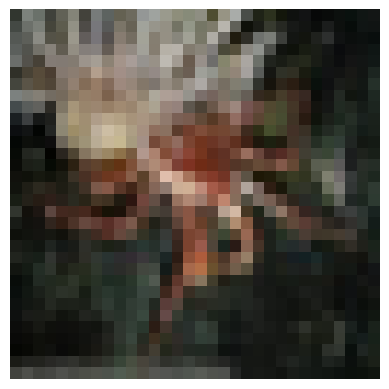


Top predictions:

            crab: 21.78%
          spider: 19.82%
   aquarium_fish: 8.53%
       pine_tree: 5.34%
       palm_tree: 4.64%


In [3]:
# Randomly pick an image from the dataset
image, class_id = cifar100[100]
image_input = preprocess(image).unsqueeze(0).to(device)
# token
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)
# Plot the image
print(f"Top predictions for {cifar100.classes[class_id]}:")
plt.imshow(image)
plt.axis('off')
plt.show()
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

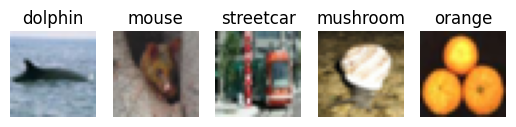

In [4]:
# token
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
# Randomly pick 5 images from the dataset
fig, axs = plt.subplots(1, 5)
for i in range(5):
    image, class_id = cifar100[np.random.randint(0, 10000)]
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)
    axs[i].imshow(image)
    axs[i].set_title(f"{cifar100.classes[indices[0]]}")
    axs[i].axis('off')
plt.show()

# Use Features to Train a Model

In [5]:
# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


In [6]:
# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 80.000


c:\Users\jimaz\anaconda3\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
